<a href="https://colab.research.google.com/github/wzummo/Neural_Network_approximation_of_PDE/blob/main/Burgers_first_attempt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Burgers Equation example


1. x and t domain respectively
* [-1,1]x[0,1]

2. Where x and t are the inputs and u is returned as a solution to the equaiton:
* $\frac{∂u}{∂t} + u \frac{∂u}{∂x} -\frac{0.01}{\pi} \frac{∂^2u}{∂x^2} = 0$

3. with initial condition of:
* $u(x, t=0) = -sin(\pi x)$

4. and boundary condition of:
* $u(x=-1,t) = 0$ and $u(x=1,t)=0$

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

## data generation

In [2]:
# take 25 boundary condition samples
n_samples_bc = 25

# first boundary condition: u(x=-1, t) = 0

# generate x data when x=-1
x0_BC_1 = -1*np.ones(n_samples_bc).reshape(n_samples_bc,1)     # reshape to give second dimension

# generate t data between 0,1
t0_BC_1 = np.linspace(0,1,n_samples_bc).reshape(n_samples_bc,1)

# since u = 0 at this boundary condition
u0_BC_1 = np.zeros(n_samples_bc).reshape(n_samples_bc,1)

# second boundary condition: u(x=1, t) = 0

# generate x data when x=1
x0_BC_2 = np.ones(n_samples_bc).reshape(n_samples_bc,1)     # reshape to give second dimension

# generate t data between 0,1
t0_BC_2 = np.linspace(0,1,n_samples_bc).reshape(n_samples_bc,1)

# since u = 0 at this boundary condition
u0_BC_2 = np.zeros(n_samples_bc).reshape(n_samples_bc,1)

In [3]:
# take 50 initial condition samples
n_samples_ic = 50

# initial condition: u(x, t=0) = -sin(\pi x)

# equally spaced x's on the domain [-1,1]
x0_IC = np.linspace(-1,1,n_samples_ic).reshape(n_samples_ic,1)

# t=0 at the IC
t0_IC = np.zeros(n_samples_ic).reshape(n_samples_ic,1)

# u is given by u(x, t=0) = -sin(\pi x)
u0_IC = -np.sin(np.pi*x0_IC).reshape(n_samples_ic,1)

In [4]:
# group data together 
X0 = np.concatenate([x0_IC, x0_BC_1, x0_BC_2])
T0 = np.concatenate([t0_IC, t0_BC_1, t0_BC_2])
U0 = np.concatenate([u0_IC, u0_BC_1, u0_BC_2])

In [5]:
# Select 10,000 points to enforce the output of the network to fulfill the Burger's equation.
n_samples_coll = 10000

from scipy.stats import qmc

sampler = qmc.Sobol(2)
points = sampler.random(n_samples_coll)

# since this returns between 0 and 1
print(min(points[:,0]), max(points[:,0]))

# for x data 
x_data = 2*points[:,0] - 1 # this returns it between -1 and 1 
x_data = x_data.reshape(n_samples_coll,1)
print(min(x_data), max(x_data))

# while for t it already is between 0 and 1
t_data = points[:,1].reshape(n_samples_coll,1)
print(min(t_data), max(t_data))

3.1813979148864746e-06 0.9999810457229614
[-0.99999364] [0.99996209]
[4.31882218e-05] [0.99989426]


/usr/local/lib/python3.7/dist-packages/scipy/stats/_qmc.py:1078: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"


In [6]:
x_tensor = tf.convert_to_tensor(x_data, dtype=tf.float32)
t_tensor = tf.convert_to_tensor(t_data, dtype=tf.float32)
x0_tensor = tf.convert_to_tensor(X0, dtype=tf.float32)
t0_tensor = tf.convert_to_tensor(T0, dtype=tf.float32)
u0_tensor = tf.convert_to_tensor(U0, dtype=tf.float32)

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_tensor, t_tensor))

batch_size = 100
train_dataset_shuffled = train_dataset.shuffle(10000).batch(batch_size)

# define and initialize model 

In [8]:
def create_model():
  inputs = tf.keras.Input((2))
  L1 = tf.keras.layers.Dense(20, activation='tanh')(inputs)
  L2 = tf.keras.layers.Dense(20, activation='tanh')(L1)
  L3 = tf.keras.layers.Dense(20, activation='tanh')(L2)
  L4 = tf.keras.layers.Dense(20, activation='tanh')(L3)
  L5 = tf.keras.layers.Dense(20, activation='tanh')(L4)
  L6 = tf.keras.layers.Dense(20, activation='tanh')(L5)
  L7 = tf.keras.layers.Dense(20, activation='tanh')(L6)
  L8 = tf.keras.layers.Dense(20, activation='tanh')(L7)
  L9 = tf.keras.layers.Dense(20, activation='tanh')(L8)
  outputs = tf.keras.layers.Dense(1, activation='tanh')(L9)

  model = tf.keras.Model(inputs=inputs, outputs=outputs)
  return model

$\frac{∂u}{∂t} + u \frac{∂u}{∂x} -\frac{0.01}{\pi} \frac{∂^2u}{∂x^2} = 0$

In [9]:
def MSE(y_pred, y_true=None):
    '''mean square error of y_pred - y_true if y_true is given, else mean sqaure error of y_pred'''
    if y_true is None:
        return tf.reduce_mean(y_pred ** 2)
    else:
        return tf.reduce_mean((y_pred - y_true) ** 2)

In [10]:
def loss(model, x, t, x0, t0, u0):
  # residual loss for PDE
  t_copy = tf.identity(t)
  x_copy = tf.identity(x)
  with tf.GradientTape() as touter:
    touter.watch([t_copy, x_copy])
    with tf.GradientTape(persistent=True) as t:
      t.watch([t_copy, x_copy])
      x_and_t = tf.concat([x_copy,t_copy],1)
      u_pred = model(x_and_t)
    Ut = t.gradient(u_pred, t_copy)
    Ux = t.gradient(u_pred, x_copy)
  Uxx = touter.gradient(Ux, x_copy)

  res = Ut + u_pred*Ux - (0.01/np.pi)*Uxx
  res_loss = sum([MSE(res_i) for res_i in res]) 
  

  # inital condition and boundary (icab)
  x_and_t_icab = tf.concat([x0,t0],1)
  icab_pred = model(x_and_t_icab)
  icab_loss = sum([MSE(icab_pred, u0)])

  total_loss = res_loss + icab_loss
  
  return total_loss

In [13]:
model = create_model()

epochs = 20
optimizer = tf.keras.optimizers.Adagrad(0.01)

for epoch in range(epochs):
  for x_batch, t_batch in train_dataset_shuffled:
    with tf.GradientTape() as t_opt:
      total_loss = loss(model, x_batch, t_batch, x0_tensor, t0_tensor, u0_tensor)
    optimizer.minimize(total_loss, [model.trainable_variables], tape=t_opt)

  if epoch % 1 == 0:
    print(f'Epoch = {epoch}, Loss = {total_loss.numpy()}')


Epoch = 0, Loss = 0.22934146225452423
Epoch = 1, Loss = 0.21494071185588837
Epoch = 2, Loss = 0.20891988277435303
Epoch = 3, Loss = 0.20653735101222992
Epoch = 4, Loss = 0.2036811113357544
Epoch = 5, Loss = 0.20363545417785645
Epoch = 6, Loss = 0.2015700340270996
Epoch = 7, Loss = 0.19836166501045227
Epoch = 8, Loss = 0.19821660220623016
Epoch = 9, Loss = 0.19562508165836334
Epoch = 10, Loss = 0.19474583864212036
Epoch = 11, Loss = 0.19159770011901855
Epoch = 12, Loss = 0.19289013743400574
Epoch = 13, Loss = 0.19088990986347198
Epoch = 14, Loss = 0.18807682394981384
Epoch = 15, Loss = 0.18718264997005463
Epoch = 16, Loss = 0.18542340397834778
Epoch = 17, Loss = 0.18600031733512878
Epoch = 18, Loss = 0.18520627915859222
Epoch = 19, Loss = 0.18531301617622375


In [14]:
import scipy.integrate as integrate  

In [15]:
from numpy import sqrt, sin, cos, pi, exp, inf

In [16]:
def solve_burgers(X, t, nu):  
  def f(y):
    return exp(-cos(pi*y)/(2*pi*nu))

  def g(y):
    return exp(-(y**2)/(4*nu*t))

  def fun_1(eta):
    return sin(pi*(x-eta))*f(x-eta)*g(eta)

  def fun_2(eta):
    return f(x-eta)*g(eta)

  # Initialize solutions
  U = np.zeros_like(X)

  # loop over x's
  for i in range(len(X)):
    x = X[i]

    if abs(x) != 1:
      uxt = -integrate.quad(fun_1, -inf, inf)[0]
      vxt = integrate.quad(fun_2, -inf, inf)[0]
      U[i] = uxt / vxt
      
  return U

In [17]:
t_test = [0.25, 0.5, 0.75, 1]
numPredictions = 1000
x_test = np.linspace(-1,1,numPredictions).reshape(numPredictions, -1)

prediction_list = []
true_value_list = []

for time in t_test:

  ts = time*np.ones(numPredictions).reshape(numPredictions, -1)

  true_value = solve_burgers(x_test, time, 0.01/pi)
  true_value_list.append(true_value)

  x_test_tensor = tf.convert_to_tensor(x_test, dtype = tf.float32)
  ts_tensor = tf.convert_to_tensor(ts, dtype = tf.float32)

  inputs_x_t_test = tf.concat([x_test_tensor,ts_tensor],1)

  predictions = model(inputs_x_t_test)
  prediction_list.append(predictions)

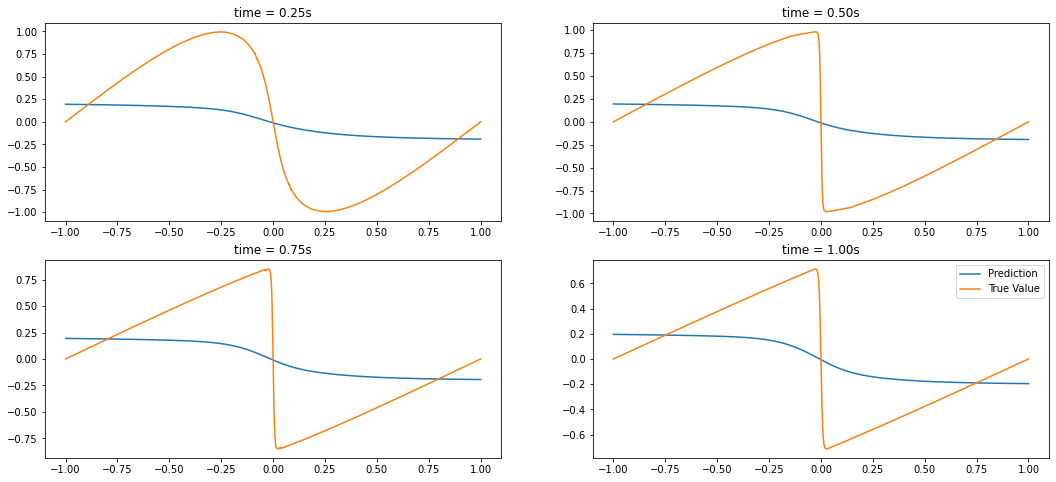

In [18]:
fig, ax = plt.subplots(2,2, figsize=(18,8), )
ax[0,0].plot(x_test_tensor, prediction_list[0], label='Prediction'), ax[0,0].set_title('time = 0.25s')
ax[0,0].plot(x_test_tensor, true_value_list[0], label='True Value')

ax[0,1].plot(x_test_tensor, prediction_list[1], label='Prediction'), ax[0,1].set_title('time = 0.50s')
ax[0,1].plot(x_test_tensor, true_value_list[1], label='True Value')

ax[1,0].plot(x_test_tensor, prediction_list[2], label='Prediction'), ax[1,0].set_title('time = 0.75s')
ax[1,0].plot(x_test_tensor, true_value_list[2], label='True Value')

ax[1,1].plot(x_test_tensor, prediction_list[3], label='Prediction'), ax[1,1].set_title('time = 1.00s')
ax[1,1].plot(x_test_tensor, true_value_list[3], label='True Value')

plt.legend()